In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as torchdist
import torch.nn as nn

In [2]:
normal_dist = torchdist.Normal(loc=torch.tensor(0.), scale=torch.tensor(1.))

In [3]:
x = normal_dist.sample()

In [4]:
x

tensor(-1.6541)

In [5]:
x = normal_dist.sample([100])

In [6]:
x

tensor([ 0.0771, -1.5466,  0.2884,  1.0425,  0.5454, -0.7535, -0.8863, -1.9649,
         1.4845, -1.2679,  1.5053,  0.3087,  0.8753, -0.7226, -0.2196, -0.7932,
        -1.7360, -2.8748,  0.6508,  0.6414, -0.1379,  0.5310,  0.7292,  1.0037,
         0.3915, -0.3077, -1.6156, -1.0584,  0.3957,  2.3781,  0.0935, -2.0646,
        -0.5939, -0.1284, -0.1470,  0.9330, -0.7404,  1.4943, -0.1264,  0.5002,
         0.3606,  1.1733, -1.0369, -0.1545,  1.6796, -0.1438, -0.5004,  0.1363,
         0.3740, -1.0412,  0.1299, -0.2962, -1.4899, -2.0192, -0.0910, -0.3518,
         2.6431,  1.1347, -0.4285,  0.1258,  0.8439, -0.7216, -0.1777, -0.9818,
        -0.5263,  0.4214, -1.2704,  0.5404, -0.5254, -1.1265, -1.7954, -0.9965,
         0.7182, -2.6893,  0.3045, -0.5148, -0.1577, -0.1463, -0.0425, -0.2962,
         0.2282,  1.2408, -1.7098, -1.0748,  0.0246,  0.3392, -0.7891,  0.0578,
         0.0186, -2.2881,  0.2632,  1.7177, -0.5182,  0.8976, -0.1576,  1.5942,
         0.7322,  0.2230, -0.6350, -1.12

(array([ 2.,  5.,  7., 15., 23., 22., 13.,  8.,  3.,  2.]),
 array([-2.8748193 , -2.323025  , -1.7712307 , -1.2194365 , -0.66764224,
        -0.11584795,  0.43594632,  0.9877406 ,  1.5395348 ,  2.091329  ,
         2.6431234 ], dtype=float32),
 <a list of 10 Patch objects>)

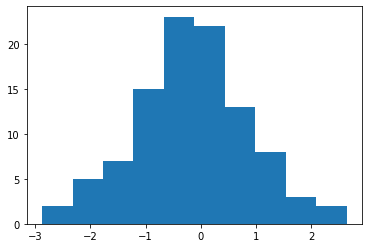

In [7]:
plt.hist(x.detach().numpy())

In [8]:
def toy_poly():
    x = 5 * torch.rand(100, 1)
    linear_op = -3 - 4*x + x**2
    y = torchdist.Normal(linear_op, 1).sample()
    return x, y

x_train, y_train = toy_poly()

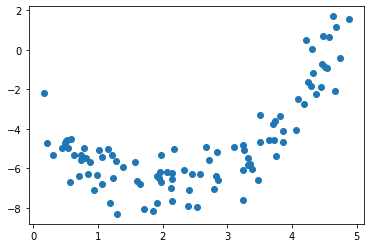

In [9]:
plt.plot(x_train.numpy(), y_train.numpy(), 'o')

## model

In [10]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        
    def forward(self, w, x):
        """
        w: shape of (3,)
        x: shape of (batch,)
        """
        #         phi_x = torch.tensor([])
        y = w[0] + w[1]*x + w[2]*x**2
        return y

In [11]:
class VImodel(nn.Module):
    """
    q(w; eta)
    """
    def __init__(self):
        super(VImodel, self).__init__()
        self.eta_mu = nn.Parameter(torch.tensor([0., 0., 0.]))
        self.eta_log_sigma = nn.Parameter(torch.tensor([0., 0., 0.]))
    
    def dist(self):
        eta_sigma = torch.exp(self.eta_log_sigma)
        q_w = torchdist.Normal(self.eta_mu, eta_sigma)
        
        return q_w
    '''
    def rsample(self):
        eta_sigma = torch.exp(self.eta_log_sigma)
        q_w = torchdist.Normal(self.eta_mu, eta_sigma)
        
        # shape of w: (3,)
        w = q_w.rsample()
        
        return w
    '''

In [12]:
def kl_divergence(vmodel, model, x, y):
    q_w = vmodel.dist()
    w_sample = q_w.rsample()    
    
    output = model(w_sample, x)    
    
    # p(y|x,w) = N(f(x; w), 1)
    p_y_xw = torchdist.Normal(output, torch.ones_like(output))
    # p(w) = N(0, 10)
    p_w = torchdist.Normal(torch.tensor([0., 0., 0.]), torch.tensor([10., 10., 10.]))
    
    # log(p(w, x, y)) = log(p(w)) + 1/n * sigma(log(p(y|x,w)))
    val_log_joint_prob = p_w.log_prob(w_sample).sum() + p_y_xw.log_prob(y).mean()
    
    val_log_q_w = q_w.log_prob(w_sample).sum()
    
    return val_log_q_w - val_log_joint_prob

In [20]:
vimodel = VImodel()
model = LinearNet()
optimizer = torch.optim.SGD(params=vimodel.parameters(), lr=1e-4)

In [21]:
for i in range(10000):
    optimizer.zero_grad()
    loss = kl_divergence(vimodel, model, x_train, y_train)
    loss.backward()
    optimizer.step()
    
    if (i+1) % 500 == 0 or (i==0):
        print('loss: %f mu: %s' % (loss.detach().numpy(), str(vimodel.eta_mu.detach().numpy())))

loss: 26.812496 mu: [-0.00021048  0.0002079   0.00241458]
loss: 18.832735 mu: [-0.15953322 -0.20465852 -0.18758607]
loss: 21.290607 mu: [-0.29363307 -0.3346249  -0.11052269]
loss: 17.090652 mu: [-0.42486292 -0.47146088 -0.09016807]
loss: 17.018867 mu: [-0.54783016 -0.590821   -0.02180043]
loss: 17.026001 mu: [-0.66617954 -0.70755076  0.03447024]
loss: 20.906048 mu: [-0.7864518 -0.8387914  0.0219383]
loss: 25.302828 mu: [-0.89560825 -0.9479581   0.06749553]
loss: 16.262108 mu: [-1.0036962  -1.0597554   0.09145799]
loss: 18.547161 mu: [-1.0997602  -1.1511965   0.15948977]
loss: 20.494411 mu: [-1.1986444  -1.255567    0.16997397]
loss: 14.492522 mu: [-1.2912115 -1.3467085  0.2169843]
loss: 14.101868 mu: [-1.3817797  -1.443674    0.22008407]
loss: 15.475110 mu: [-1.4657048  -1.5261906   0.26431867]
loss: 14.671127 mu: [-1.5480297 -1.6125643  0.2782606]
loss: 14.154516 mu: [-1.6239567  -1.6860789   0.32570735]
loss: 14.538898 mu: [-1.6999624 -1.7652081  0.3416909]
loss: 12.164493 mu: [-1.77

loss: 11.719726 mu: [-3.353878  -3.573086   0.9146844]
loss: 12.809627 mu: [-3.3543918 -3.576275   0.9060949]
loss: 12.064063 mu: [-3.3511655 -3.5696478  0.9301079]
loss: 11.568466 mu: [-3.3513844  -3.5737927   0.91373783]
loss: 11.628743 mu: [-3.353008  -3.5788558  0.9000982]
loss: 9.330519 mu: [-3.3528156 -3.5770175  0.9141305]
loss: 15.873258 mu: [-3.3541765  -3.5800843   0.90932024]
loss: 13.402539 mu: [-3.3521583  -3.5752175   0.92895955]
loss: 11.002305 mu: [-3.351418   -3.576003    0.92601264]
loss: 11.248577 mu: [-3.3505647  -3.5751953   0.93055385]
loss: 13.229175 mu: [-3.3516867 -3.5799909  0.9157701]
loss: 12.989222 mu: [-3.3521278  -3.5828052   0.90816045]
loss: 11.116403 mu: [-3.351585   -3.5824256   0.91232663]
loss: 11.413358 mu: [-3.350495   -3.5806277   0.92090446]
loss: 12.359845 mu: [-3.3501978 -3.5803056  0.9251296]
loss: 13.074423 mu: [-3.3473878 -3.5753076  0.94213  ]
loss: 12.771024 mu: [-3.3478196 -3.5803118  0.9224297]
loss: 13.472776 mu: [-3.3506873 -3.5892558

In [15]:
vimodel.eta_mu

Parameter containing:
tensor([-1.8370, -1.9110,  0.3676], requires_grad=True)

In [16]:
vimodel.eta_log_sigma

Parameter containing:
tensor([ 4.8414e-04, -9.9436e-01, -2.3029e+00], requires_grad=True)

In [21]:
q = torchdist.Normal(torch.tensor([0., 10.]), torch.tensor([1., 1.]))
w = q.sample()

In [22]:
w.size()

torch.Size([2])

(array([ 5.,  5., 13., 25., 17., 14.,  9.,  4.,  3.,  5.]),
 array([ 8.144145 ,  8.580228 ,  9.016312 ,  9.4523945,  9.888477 ,
        10.32456  , 10.760644 , 11.196727 , 11.63281  , 12.068893 ,
        12.504976 ], dtype=float32),
 <a list of 10 Patch objects>)

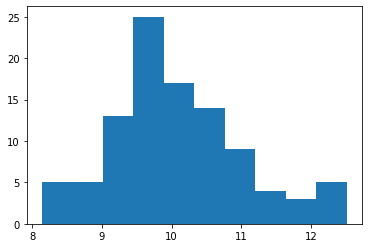

In [20]:
plt.hist(w[:,1].numpy())

In [12]:
def log_joint_prob(w0, w1, w2, x, y):
    prior_w0 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    prior_w1 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    prior_w2 = torchdist.Normal(torch.tensor(0.), 10*torch.tensor(1.))
    
    linear = w0 + w1*x + w2*x**2
    likelihood = torchdist.Normal(linear, torch.ones_like(linear))
    
    return (
        prior_w0.log_prob(w0) +
        prior_w1.log_prob(w1) +
        prior_w2.log_prob(w2) +
        likelihood.log_prob(y).mean()
    )

In [13]:
w0 = torch.nn.Parameter(torch.tensor(1.))
w1 = torch.nn.Parameter(torch.tensor(1.))
w2 = torch.nn.Parameter(torch.tensor(1.))

optimizer = torch.optim.Adam(params=[w0, w1, w2], lr=1e-3)

for i in range(30000):
    optimizer.zero_grad()
    log_joint_prob_value = log_joint_prob(w0, w1, w2, x_train, y_train)
    loss_value = - log_joint_prob_value
    loss_value.backward()
    optimizer.step()
    
    if (i+1) % 1000 == 0 or (i==0):
        print(loss_value.detach().numpy())

174.15164
38.347015
20.815247
18.843868
16.873156
14.854201
13.132132
11.94904
11.34323
11.142217
11.097228
11.072759
11.048522
11.029579
11.019746
11.017018
11.01674
11.016734
11.016733
11.016733
11.016733
11.016733
11.016733
11.016733
11.016734
11.016734
11.016733
11.016734
11.016733
11.016733
11.016733


In [15]:
print(w0)
print(w1)
print(w2)

Parameter containing:
tensor(-2.8305, requires_grad=True)
Parameter containing:
tensor(-3.9310, requires_grad=True)
Parameter containing:
tensor(0.9795, requires_grad=True)
